CIS 678 Challenge 3
===================

This notebook uses a C++ backend using Eigen and OpenMP for linear algebra and parallelization. The python module neuralnet is created from this backend uing PyBind11.

The C++ source defines a class NeuralNetwork, which implements the forward and backward propatgation algorithms.


The following have been tested using pytest:
- The model can be constructed without errors
- A forward pass can be run without errors
- A backward pass can be run without errors
- The model can be trained to implement the behavior of an XOR gate

In [19]:
# Import C++ perceptron implementation
import neuralnet as nn
# Import other libraries
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Load training data
TRAIN_IN = np.genfromtxt('data/mnist_train.csv', delimiter=',', skip_header=1)

targets = np.genfromtxt('data/mnist_train_targets.csv', delimiter=',', skip_header=1)
TRAIN_OUT = []
for t in targets:
    out = [0] * 10
    out[int(t)] = 1
    TRAIN_OUT.append(out)

TEST_IN = np.genfromtxt('data/mnist_test.csv', delimiter=',', skip_header=1)

# Define a function to format and save data for submission
def save_result(data, filename):
    if not ('.csv' in filename):
            filename += '.csv'

    # Format results in the format kaggle wants 
    results_out = [["\"Id\"","\"Expected\""]]
    for i in range(0, len(data)):
        results_out.append([f"\"{i+1}\"", f"\"{int(data[i])}\""])


    np.savetxt(F"results/{filename}", results_out, delimiter=',', fmt="%s")


Set input images to binary black/white

In [21]:
for i in range(TRAIN_IN.shape[1]):
    TRAIN_IN[:,i] /= np.linalg.norm(TRAIN_IN[:,i])

Basic Perceptron Based Prediction
---------------------------------
Format the data into slices of 10 days, where the first 9 are used for training and the 10th is used to test the output. Perform backpropagation over this data, then run a forward pass on the final slice of 9 days for each stock to make a final prediction. 

Construct and train the mode.
For now, just guessing at model parmeters

In [26]:
dims = [TRAIN_IN.shape[0]]
dims.extend([15] * 3)
funcs = [nn.ActivationFunctions.ReLU] * 4

model = nn.NeuralNetwork([TRAIN_IN.shape[0], *dims,  10],    [*funcs, nn.ActivationFunctions.SoftMax])
errors = model.train(
    [TRAIN_IN[:,i] for i in range(TRAIN_IN.shape[1])], 
    TRAIN_OUT, 
    1/TRAIN_IN.shape[1], 5
)

IndexError: invalid vector subscript

Display a plot of the error as backpropagation progresses, to verify that the model is converging

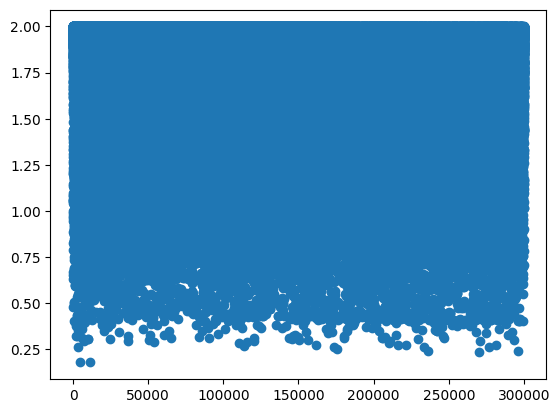

In [23]:
plt.scatter(range(len(errors)), errors)

Now, generate the final results

In [24]:
results = []
for dig in [TEST_IN[:,i] for i in range(TEST_IN.shape[1])]:
    out = model.forwardPass(dig)
    results.append(np.argmax(out))

save_result(results, "basic_perceptron")

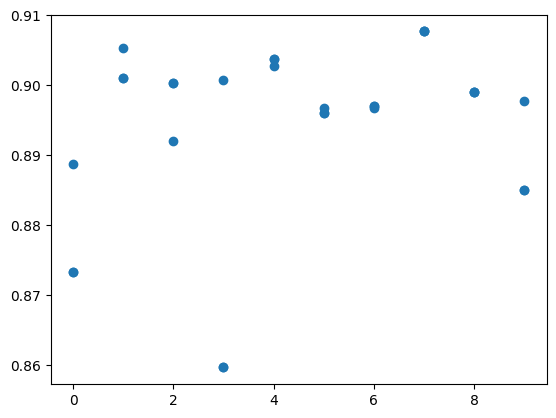

In [25]:
# Try some cross validation of different network depths
errors = []
lengths = []

for i in range(10):
    dims = dims = [TRAIN_IN.shape[0]]
    funcs = [nn.ActivationFunctions.ReLU]

    dims.extend([25] * i)
    funcs.extend([nn.ActivationFunctions.ReLU] * i)

    dims.append(10)
    funcs.append(nn.ActivationFunctions.SoftMax)

    e = nn.test(dims, funcs,  
        [TRAIN_IN[:,i] for i in range(TRAIN_IN.shape[1])], TRAIN_OUT, 
        0.05, 3,
        1/TRAIN_IN.shape[1], 5
    )

    errors.extend(e)
    lengths.extend([i] * len(e))

plt.scatter(lengths, errors)